In [255]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [256]:
###GLOBAL VARIABLES####
K = 32
starting_ELO = 1000
highest_ELO_ever = [starting_ELO, "team", "season", "week"]

In [257]:
def calc_new_ELO(season: str, week: str, home_team: str, away_team: str, ELO_dict : dict, result: str, K:int, top_rating) -> dict: 
    prior_ELO_home = ELO_dict[home_team]
    prior_ELO_away = ELO_dict[away_team]
    expected_result_home = 1 / (1 + np.power(10, ((prior_ELO_away - prior_ELO_home)/ 400)))
    expected_result_away = 1 / (1 + np.power(10, ((prior_ELO_home - prior_ELO_away)/ 400)))
    
    if result == "H": 
        S = 1.
    elif result == "A":
        S = 0.
    else: 
        S = 0.5

    new_ELO_home = prior_ELO_home + K*(S - expected_result_home)
    new_ELO_away = prior_ELO_away + K*(1-S - expected_result_away)
    if new_ELO_home > top_rating[len(top_rating)-1][0]: 
        top_rating.append([new_ELO_home, home_team, season, week])
        print("The highest ELO record has been broken by ", home_team, " after a home victory against ", away_team, " on match-week ", week, " of the ", season , "season " )
        print(" the new top elo ever is ", new_ELO_home)
    elif new_ELO_away > top_rating[len(top_rating)-1][0].astype(int): 
        top_rating.append([new_ELO_away, away_team, season, week])
        print("The highest ELO record has been broken by ", away_team, " after a away victory against ", home_team, " on match-week ", week, " of the ", season , "season " )
        print(" the new top elo ever is ", new_ELO_away)

    ELO_dict[home_team] = new_ELO_home
    ELO_dict[away_team] = new_ELO_away

    return ELO_dict, top_rating

In [258]:
raw_data = np.genfromtxt("premier_league_data/premier-league-matches.csv", delimiter=",", skip_header=True, dtype=str)


In [259]:
needed_data = raw_data[:,[0,1,3,6,7]] #We only need the season, round, home team, away team and result
#The elo enginge doesn't consider the margin by which a team won. 
#We choose the round instead of the date, because it is esier to work with. 
#We therefore pretend that a match in round 5 always happened before a match in round 4, even though this isn't always true

In [260]:
all_teams = np.unique(needed_data[:,3])
print("All the teams who ever play on home ground ", all_teams)
#We look at all the unique teams, and are blessed with the fact, that there are no duplicates or weird names
#The data seems good. 

All the teams who ever play on home ground  ['Arsenal' 'Aston Villa' 'Barnsley' 'Birmingham City' 'Blackburn'
 'Blackpool' 'Bolton' 'Bournemouth' 'Bradford City' 'Brentford' 'Brighton'
 'Burnley' 'Cardiff City' 'Charlton Ath' 'Chelsea' 'Coventry City'
 'Crystal Palace' 'Derby County' 'Everton' 'Fulham' 'Huddersfield'
 'Hull City' 'Ipswich Town' 'Leeds United' 'Leicester City' 'Liverpool'
 'Manchester City' 'Manchester Utd' 'Middlesbrough' 'Newcastle Utd'
 'Norwich City' "Nott'ham Forest" 'Oldham Athletic' 'Portsmouth' 'QPR'
 'Reading' 'Sheffield Utd' 'Sheffield Weds' 'Southampton' 'Stoke City'
 'Sunderland' 'Swansea City' 'Swindon Town' 'Tottenham' 'Watford'
 'West Brom' 'West Ham' 'Wigan Athletic' 'Wimbledon' 'Wolves']


In [261]:
ELO_of_teams = {value: starting_ELO for value in all_teams}
#Now we give all teams their starting ELO

In [262]:
first_season = needed_data[needed_data[:,0] == "1993"]

In [263]:
first_season_sorted = first_season[first_season[:,1].astype(int).argsort()]
#Take out only first season to test on

In [264]:
ELO_of_teams = {value: starting_ELO for value in all_teams}
highest_ELO_ever = [[starting_ELO, "team", "season", "week"]]

for match in first_season_sorted: 
    ELO_of_teams, highest_ELO_ever = calc_new_ELO(match[0], match[1], match[2], match[3], ELO_of_teams, match[4] , 32, highest_ELO_ever)

The highest ELO record has been broken by  Coventry City  after a home victory against  Middlesbrough  on match-week  1  of the  1993 season 
 the new top elo ever is  1016.0
The highest ELO record has been broken by  Sheffield Weds  after a home victory against  Nott'ham Forest  on match-week  2  of the  1993 season 
 the new top elo ever is  1016.736306793522
The highest ELO record has been broken by  Norwich City  after a home victory against  Chelsea  on match-week  2  of the  1993 season 
 the new top elo ever is  1031.263693206478
The highest ELO record has been broken by  Coventry City  after a away victory against  Tottenham  on match-week  2  of the  1993 season 
 the new top elo ever is  1031.263693206478
The highest ELO record has been broken by  Coventry City  after a away victory against  Wimbledon  on match-week  3  of the  1993 season 
 the new top elo ever is  1044.4148906697776
The highest ELO record has been broken by  QPR  after a away victory against  Coventry City 

In [265]:
sorted_matches = sorted(needed_data, key=lambda x: (x[0].astype(int), x[1].astype(int)))
#I sort the games by match-week

In [266]:
ELO_of_teams = {value: starting_ELO for value in all_teams}
highest_ELO_ever = [[starting_ELO, "team", "season", "week"]]
for match in sorted_matches: 
    ELO_of_teams, highest_ELO_ever = calc_new_ELO(match[0], match[1], match[2], match[3], ELO_of_teams, match[4] , 32, highest_ELO_ever)



The highest ELO record has been broken by  Coventry City  after a home victory against  Middlesbrough  on match-week  1  of the  1993 season 
 the new top elo ever is  1016.0
The highest ELO record has been broken by  Coventry City  after a away victory against  Tottenham  on match-week  2  of the  1993 season 
 the new top elo ever is  1031.263693206478
The highest ELO record has been broken by  Coventry City  after a away victory against  Wimbledon  on match-week  3  of the  1993 season 
 the new top elo ever is  1044.4148906697776
The highest ELO record has been broken by  QPR  after a away victory against  Coventry City  on match-week  4  of the  1993 season 
 the new top elo ever is  1047.8046277230412
The highest ELO record has been broken by  Norwich City  after a home victory against  Southampton  on match-week  7  of the  1993 season 
 the new top elo ever is  1054.6692680176461
The highest ELO record has been broken by  Norwich City  after a away victory against  Chelsea  on 

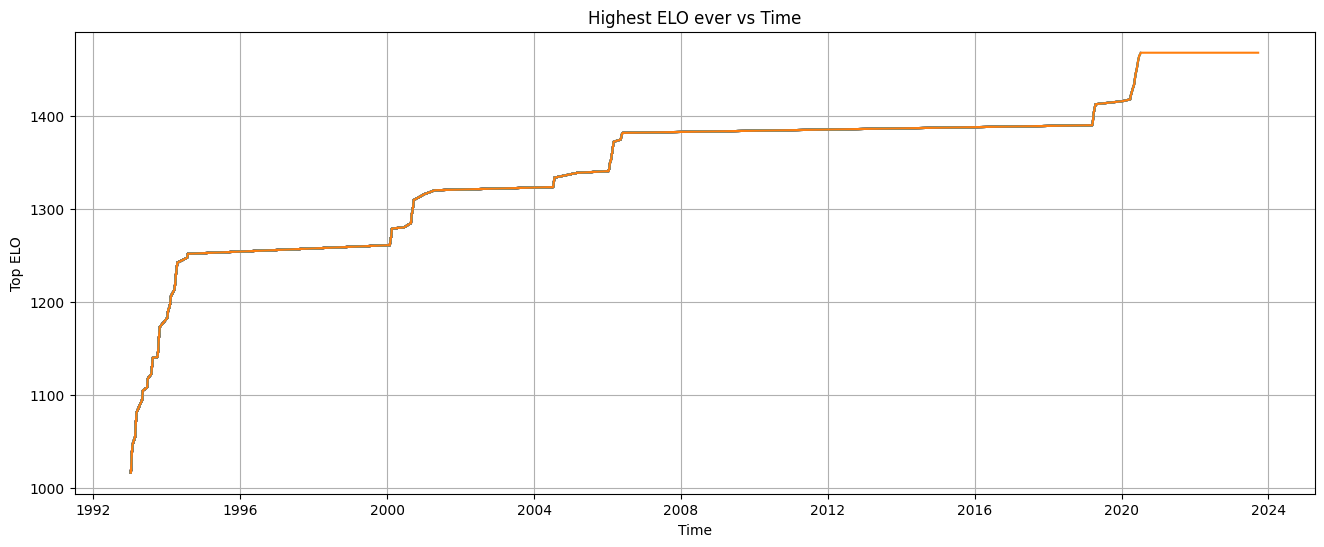

In [281]:
highest_ELO_ever.append([highest_ELO_ever[len(highest_ELO_ever)-1][0], highest_ELO_ever[len(highest_ELO_ever)-1][1], '2023', '38'])
def year_week_to_date(year, week):
    year_int = int(year)
    week_int = int(week)
    # Calculate the date for the first day of the week
    first_day_of_week = datetime.strptime(f'{year_int}-{week_int}-1', "%Y-%W-%w")
    # Add 3 days because the first week of the year might belong to the previous year
    first_day_of_week += timedelta(days=3)
    return first_day_of_week

# Plotting
plt.figure(figsize=(16, 6))
x_values = []
y_values = []
for entry in highest_ELO_ever[:][1:]:
    value, team, year, week = entry
    date = year_week_to_date(year, week)
    x_values.append(date)
    y_values.append(value)
    plt.plot(x_values, y_values, linestyle='-')

plt.xlabel('Time')
plt.ylabel('Top ELO')
plt.title('Highest ELO ever vs Time')
plt.grid(True)
plt.show()